# Data Transfer

### This notebook has information regarding the data transfer per latitude in 12 day chunks run for 60 days

In [21]:
from lusee.observation import LObservation
from lusee.lunar_satellite import LSatellite, ObservedSatellite
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import time

## The demodulation function below follows the formula from the excel sheet. Each variable closely matches the varibles from excel sheet

In [22]:
def demodulation(dis_range, rate_pw2, extra_ant_gain):
    R = np.array([430,1499.99,1500,1999.99,2000,2999.99,3000,4499.99,4500,7499.99,7500,10000])
    Pt_error = np.array([11.00,11.00,8.50,8.50,6.00,6.00,4.00,4.00,3.00,3.00,2.50,2.50])
    Antenna_gain = np.arange(11)
    SANT = np.array([21.8,21.8,21.6,21.2,20.6,19.9,18.9,17.7,16.4,14.6,12.6])
    
    Srange_max = 8887.0   #Slant Range
    Srange_min = 2162.0
    Srange_mean = 6297.0

    Freq_MHz = 2250.0
    Asset_EIRP = 13.0 + extra_ant_gain#dBW

    Srange = dis_range

    free_space_path_loss = -20*np.log10(4*np.pi*Freq_MHz*1000000*Srange*1000/300000000)

    R_interp = np.linspace(430,10000,1000)
    Pt_error_intp = interp1d(R,Pt_error)

    Off_pt_angle = 0
    Pt_error_main = Pt_error_intp(Srange)

    Antenna_gain_intp = np.linspace(0,10,1000)
    SANT_intp = interp1d(Antenna_gain,SANT,fill_value="extrapolate")
    #print(Off_pt_angle + Pt_error_main)
    SANT_main = SANT_intp(Off_pt_angle+Pt_error_main)

    Antenna_return_loss = 15
    Mismatch_loss = 10*np.log10(1-(10**(-Antenna_return_loss/20))**2)

    SC_noise_temp = 26.8
    SCGT = SANT_main + Mismatch_loss - SC_noise_temp

    Uplink_CN0 = Asset_EIRP + free_space_path_loss + SCGT - 10*np.log10(1.38e-23)

    Mod_loss = 0.0  #says calculated but given
    Implementation_loss = -1.0  #assumed
    Pll_bw_Hz = 700 #assumed
    Pll_bw_dB = 10*np.log10(Pll_bw_Hz)
    SN_loop = 17.9470058901322

    Carrier_margin = Uplink_CN0 + Implementation_loss - Pll_bw_dB - SN_loop

    Coded_symb_rt_input = rate_pw2
    Coded_symb_rt = 2**Coded_symb_rt_input

    Code_rate = 0.662430862918876   #theory
    Data_rate = Coded_symb_rt * Code_rate

    EbN0 = Uplink_CN0 + Implementation_loss - 10*np.log10(Data_rate*1000)

    Threshold_EbN0 = 2.1
    Data_demod_margin = EbN0 - Threshold_EbN0
    
    return Data_demod_margin

### The below function and the curve_fit is written to calculate the antenna gain that is added to EIRP from above function

In [23]:
def ext_gain(x,a,b,c):    
    return a*x**2 + b*x + c

In [24]:
gain_data = [6.5,4.5,0]
ang_gain = [90,60,30]

popt,pcov = curve_fit(ext_gain,ang_gain,gain_data)
popt

array([-1.38888889e-03,  2.75000000e-01, -7.00000000e+00])

## The below cell plots the histograms of altitude(deg) and Distance(Km) for 13 different latitudes from 30 to -90

In [ ]:
maxi = np.zeros(shape = 13)
mini = np.zeros(shape = 13)
avg = np.zeros(shape = 13)

for i in range(13):
    num = 30+i*(-10)
    obs    = LObservation(lunar_day = "FY2024", lun_lat_deg = num, deltaT_sec=10*60)
    S       = LSatellite()
    obsat   = ObservedSatellite(obs,S)
    transits = obsat.get_transit_indices()
    trans_time = np.array([])
    dist_lun = np.array([])
    alt_lun = np.array([])

    for j in range(len(transits)):
        k,l = transits[j]
        trans_time = np.append(trans_time,l-k)
        dist_lun = np.append(dist_lun,obsat.dist_km()[k:l])
        alt_lun = np.append(alt_lun,obsat.alt_rad()[k:l]/np.pi*180)
    
    maxi[i] = np.max(trans_time)*10/(60)
    mini[i] = np.min(trans_time)*10/(60)
    avg[i] = np.average(trans_time)*10/(60)
    
    fig, axs = plt.subplots(figsize =(10, 7))
 
    type(dist_lun)

    # was not sure on how wide the bins should be
    plt.hist2d(dist_lun, alt_lun,bins = [20,20])  
    plt.title("Time availability (10mins) -- Lat = %i deg" %num)
  
    axs.set_xlabel('distance (km)') 
    axs.set_ylabel('altitude (deg)')

    cbar = plt.colorbar()
    cbar.set_label('Transit 10Minutes')

## The cell below calculates the data transfer transfer in kbs. The variable that are commented out will be removed in next revision of this file. 

## Disclaimer: This cell takes around 90 mins to run, which includes, calculating the variables from the lusee.lunar_satellite which takes most time followed by the repetitive use of the demodulation function. I'll try to create an numpy array that saves the calculations from LObservation function, so that repeated time taking process can be saved.

### I didn't color code the speeds yet. I don't know how to do that right away, might need some time.

### I'm not comfortable with arrays yet, hence I used list to save the data transfers, which I'll optimize in future versions

In [25]:
t0 = time.time()
#main_max = np.zeros(shape = 13)
#main_min = np.zeros(shape = 13)
#main_mean = np.zeros(shape = 13)

#counti_list = []
#counti_list_max = []
#counti_list_min = []
#counti_list_mean = []

datai_list = []
datai_list_max = []
datai_list_min = []
datai_list_mean = []
for i in range(13):   # This loop iterates every calculation for 13 latitudes
    num = 30+i*(-10)
    obs    = LObservation(lunar_day = "2025-02-01 13:00:00 to 2025-04-01 16:00:00",lun_lat_deg = num, deltaT_sec=60)
    S       = LSatellite()
    obsat   = ObservedSatellite(obs,S)
    transits = obsat.get_transit_indices()
    
    
 #   counti = np.zeros(shape = 49)
  #  counti_max = np.zeros(shape = 49)
   # counti_min = np.zeros(shape = 49)
    #counti_mean = np.zeros(shape = 49)
 
     ## The datai_max, min, mean are not written right now.
    datai = np.zeros(shape = 49)
    datai_max = np.zeros(shape = 49)
    datai_min = np.zeros(shape = 49)
    datai_mean = np.zeros(shape = 49)
    print("loop number",i)
    for c in range(49):    #This loop iterates for 12 day chunks
        
#maxcount = np.array([])
#mincount = np.array([])
        #countcount = np.array([])
    #count_decoy = 0
    #count_decoy = np.zeros((len(transits)))
        for t in range(len(transits)):    # This loop iterates for each visible transit range
            
            #count_decoy = 0
            ti,tf = transits[t]
            if ti>24*60*(c) and ti<24*60*(c+12):
                
                for talt in obsat.alt_rad()[ti:tf]:
                    
                
                    if talt > 0.3:   # This if loop checks for the altitude > 0.3 rad; and calculates the data 
                                    # transferred for wrt the distance by caluculating the demodulation (> 3.0)
                        
                        dis_r = obsat.dist_km()[ti:tf][np.where(obsat.alt_rad()[ti:tf] == talt)]
                        #print(dis_r)
                        pw2 = 12
                        extra_gain = ext_gain(talt*180/(np.pi),*popt)
                        demod = demodulation(dis_r,pw2,extra_gain)
                        while demod <= 3.0:
                            #r
                            pw2 = pw2 - 1
                            demod= demodulation(dis_r,pw2,extra_gain)
                        
                        datai[c] = datai[c]  + 60*2**pw2
                        #counti[c] = counti[c] + 1
                        #count_decoy = count_decoy + 1
            #count_decoy = counti[c]-count_decoy
            #print(count_decoy)
                #countcount = np.append(countcount,count_decoy)
        #counti_max[c] = np.max(countcount)
        #counti_min[c] = np.min(countcount)
        #counti_mean[c] = np.average(countcount)
        #print(countcount)
    #counti_list_max.append(counti_max.tolist())
    #counti_list.append(counti.tolist())
    #counti_list_min.append(counti_min.tolist())
    #counti_list_mean.append(counti_mean.tolist())
    datai_list.append(datai.tolist())
    
    #main_max[i] = np.max(counti_max)
    #main_min[i] = np.min(counti_min)
    #main_mean[i] = np.mean(counti_mean)

print(main_max)
print(main_min)
print(main_mean)
t1 = time.time()
print("time elapsed: {}s".format(t1-t0))

loop number 0
loop number 1
loop number 2
loop number 3
loop number 4
loop number 5
loop number 6
loop number 7
loop number 8
loop number 9
loop number 10
loop number 11
loop number 12
[ 82. 124. 194. 317. 394. 427. 443. 452. 455. 454. 448. 437. 416.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 290. 377. 415.]
[ 39.24483393  48.92472818  82.43428713 149.45121242 189.05772082
 219.24983257 243.30419658 256.93997946 261.02817024 303.46666957
 379.54920344 406.90021949 415.97606692]
time elapsed: 5399.114231586456s


### ignore the above o/p, the main o/ps are below.

In [26]:
print(datai_list)

[[40396800.0, 49996800.0, 56417280.0, 59781120.0, 61593600.0, 62945280.0, 63851520.0, 65602560.0, 67338240.0, 67829760.0, 75617280.0, 79027200.0, 75386880.0, 76677120.0, 78382080.0, 80332800.0, 78520320.0, 77168640.0, 76262400.0, 74511360.0, 71301120.0, 65295360.0, 49658880.0, 37770240.0, 29767680.0, 26741760.0, 27417600.0, 32117760.0, 47892480.0, 55127040.0, 59274240.0, 61393920.0, 62469120.0, 63713280.0, 65095680.0, 66846720.0, 67491840.0, 67968000.0, 77184000.0, 79779840.0, 75909120.0, 77383680.0, 78750720.0, 77905920.0, 76830720.0, 75586560.0, 74204160.0, 71531520.0, 66370560.0], [66677760.0, 73589760.0, 78044160.0, 79872000.0, 80102400.0, 80102400.0, 80102400.0, 78366720.0, 73912320.0, 68136960.0, 69365760.0, 70410240.0, 68858880.0, 79065600.0, 88166400.0, 98019840.0, 100523520.0, 100523520.0, 100523520.0, 100369920.0, 98649600.0, 94440960.0, 80893440.0, 70955520.0, 62031360.0, 55864320.0, 56962560.0, 59243520.0, 72437760.0, 77783040.0, 80209920.0, 80778240.0, 80778240.0, 80778240

In [27]:
data_total_GB = [[z/(8*1024*1024) for z in y]for y in datai_list]

In [28]:
print(data_total_GB)

[[4.815673828125, 5.9600830078125, 6.7254638671875, 7.12646484375, 7.342529296875, 7.503662109375, 7.6116943359375, 7.8204345703125, 8.02734375, 8.0859375, 9.0142822265625, 9.4207763671875, 8.98681640625, 9.140625, 9.3438720703125, 9.576416015625, 9.3603515625, 9.19921875, 9.0911865234375, 8.8824462890625, 8.499755859375, 7.7838134765625, 5.9197998046875, 4.5025634765625, 3.548583984375, 3.1878662109375, 3.2684326171875, 3.8287353515625, 5.709228515625, 6.5716552734375, 7.0660400390625, 7.3187255859375, 7.4468994140625, 7.59521484375, 7.760009765625, 7.96875, 8.045654296875, 8.1024169921875, 9.2010498046875, 9.510498046875, 9.049072265625, 9.224853515625, 9.3878173828125, 9.287109375, 9.158935546875, 9.0106201171875, 8.8458251953125, 8.5272216796875, 7.9119873046875], [7.9486083984375, 8.7725830078125, 9.3035888671875, 9.521484375, 9.5489501953125, 9.5489501953125, 9.5489501953125, 9.342041015625, 8.81103515625, 8.12255859375, 8.26904296875, 8.3935546875, 8.2086181640625, 9.42535400390

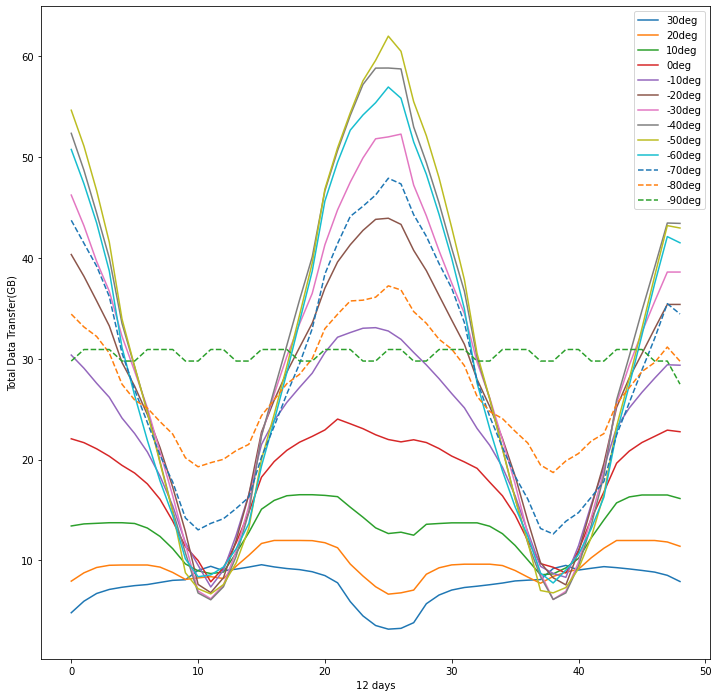

In [30]:
fig = plt.figure(figsize=(12,12))
#figsize=(15,15)
plt.plot(range(49),data_total_GB[0],label="30deg")
plt.plot(range(49),data_total_GB[1],label="20deg")
plt.plot(range(49),data_total_GB[2],label="10deg")
plt.plot(range(49),data_total_GB[3],label="0deg")
plt.plot(range(49),data_total_GB[4],label="-10deg")
plt.plot(range(49),data_total_GB[5],label="-20deg")
plt.plot(range(49),data_total_GB[6],label="-30deg")
plt.plot(range(49),data_total_GB[7],label="-40deg")
plt.plot(range(49),data_total_GB[8],label="-50deg")
plt.plot(range(49),data_total_GB[9],label="-60deg")
plt.plot(range(49),data_total_GB[10],label="-70deg",linestyle="--")
plt.plot(range(49),data_total_GB[11],label="-80deg",linestyle="--")
plt.plot(range(49),data_total_GB[12],label="-90deg",linestyle="--")
plt.xlabel("12 days") #each number represents 1 12 day chunk
plt.ylabel("Total Data Transfer(GB)")
plt.legend()
plt.show()

fig.savefig("data.png",bbox_inches = "tight")